# Data cleaning and Joining

This notebook is used to develop the process of:
- joining the two tables
- clean the salary range field
- ?

<a href='#1'>1. Join the two tables<a>   
<a href='#2'>2. Clean Salary bands<a>  
<a href='#3'>3. Conclusions/Next steps</a>

In [1]:
# Imports
import pandas as pd
import numpy as np
import regex as reg

import sys
sys.path.append( '../' )

from macaroni.data import make_data

__Load the data__

In [2]:
df_mortgage = pd.read_csv('../data/0_raw/Mortgage.csv')
print(len(df_mortgage))
df_mortgage.head(2)

32561


,full_name,dob,town,paye,salary_band,years_with_employer,months_with_employer,hours_per_week,capital_gain,capital_loss,new_mortgage,sex,religion,relationship,race,native_country,workclass,demographic_characteristic
0,Mr. Dale Coles,1979-05-10,Edinburgh,53791313,£18109 yearly,20,6,40,2174,0,Yes,Male,Christianity,Not-in-family,White,United Kingdom,State-gov,77516
1,Joel Allen,1968-07-06,Leeds,24005258,£16945 yearly,28,1,13,0,0,Yes,Male,Christianity,Husband,White,United Kingdom,Self-emp-not-inc,83311


In [3]:
df_campaign = pd.read_csv('../data/0_raw/Campaign.csv')
print(len(df_campaign))
df_campaign.head(2)

32060


,participant_id,name_title,first_name,last_name,age,postcode,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,company_email,created_account
0,8.997000e+12,Mr.,Dale,Coles,39,EH4 9FL,Never-married,Bachelors,Furniture conservator/restorer,1,17,7,9,0,jrhodes@jones.com,No
1,2.764970e+12,NaN,Joel,Allen,50,LS5H 0JG,Married-civ-spouse,Bachelors,"Administrator, sports",4,17,9,6,1,william32@carey.com,No


In [4]:
# check target variable 'created_account'
print(df_campaign['created_account'].value_counts(), '\n')
print(df_campaign['created_account'].value_counts(normalize=True))

No     2787
Yes     240
Name: created_account, dtype: int64 

No     0.920714
Yes    0.079286
Name: created_account, dtype: float64


In [5]:
df_campaign['created_account'].unique()

array(['No', 'Yes', nan], dtype=object)

## 1. Join the two tables <a id='1'></a>

There is no unique identifier in the `df_mortgage` table we can use for a direct join.
To join the tables I am using the overlapping information available in both tables.
The strategy to join the tables is a multistep approach:
1. Use the name information to do a left join. Name is not guaranteed to be unique and a left join will duplicate rows from the left table in case of a 1:many relationship. The way the names are represented in the two tables are different. I will transform the `full_name` column from `df_mortgage` to the same structure as it appears in the three column of `df_campaign`. (`name_title`, `first_name`, `last_name`).
2. Use `age` and `dob` date-of-birth information to reduce the number of duplicate participants. The year of `dob` + `age` should be around the year when the campaign was ran +/- 1 year.
3. Use the `postcode` and `town` infromation to further reduce any remaining duplicated participants. The post area part of a `postcode` is unique to a town.
4. Check if there's any duplicated `participant_id` left and drop these.

### 1.1 Crate a column we can use to merge the tables

In [6]:
# get an unique list of values for title
titles = df_campaign['name_title'].dropna().unique().tolist()
print(titles)

['Mr.', 'Miss', 'Dr.', 'Ms.', 'Mrs.']


In [7]:
# check campaign name legths
print('first name', df_campaign['first_name'].str.split(' ').apply(len).value_counts())
print('last name', df_campaign['last_name'].str.split(' ').apply(len).value_counts())

first name 1    32060
Name: first_name, dtype: int64
last name 1    32060
Name: last_name, dtype: int64


In [8]:
df_mortgage['full_name'].str.split(' ').apply(len).describe()

count    32561.000000
mean         2.942631
std          0.693619
min          2.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: full_name, dtype: float64

In [9]:
df_mortgage[['name_title', 'first_name', 'last_name']] = df_mortgage['full_name'].apply(lambda name: make_data.decompose_name(name))

In [10]:
df_mortgage.head()

,full_name,dob,town,paye,salary_band,years_with_employer,months_with_employer,hours_per_week,capital_gain,capital_loss,...,sex,religion,relationship,race,native_country,workclass,demographic_characteristic,name_title,first_name,last_name
0,Mr. Dale Coles,1979-05-10,Edinburgh,53791313,£18109 yearly,20,6,40,2174,0,...,Male,Christianity,Not-in-family,White,United Kingdom,State-gov,77516,Mr.,Dale,Coles
1,Joel Allen,1968-07-06,Leeds,24005258,£16945 yearly,28,1,13,0,0,...,Male,Christianity,Husband,White,United Kingdom,Self-emp-not-inc,83311,NaN,Joel,Allen
2,Mr. Craig Marc Davis,1979-02-10,Edinburgh,44124649,£729.87 pw,14,5,40,0,0,...,Male,Christianity,Not-in-family,White,United Kingdom,Private,215646,Mr.,Craig,Davis
3,Mr. Brandon Thornton,1965-10-20,Edinburgh,85701281,£19087 yearly,32,6,40,0,0,...,Male,Christianity,Husband,Black,United Kingdom,Private,234721,Mr.,Brandon,Thornton
4,Miss Brett Carol Fletcher,1990-02-20,Swindon,BR442000,£2741.5 per month,3,6,40,0,0,...,Female,Christianity,Wife,Black,Sweden,Private,338409,Miss,Brett,Fletcher


## Merge
#### Merge only campaign data with no missing targets

In [11]:
df_campaign_cl = df_campaign[~df_campaign['created_account'].isna()].copy()
print(len(df_campaign_cl))

3027


In [12]:
df_campaign_cl.head()

,participant_id,name_title,first_name,last_name,age,postcode,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,company_email,created_account
0,8.997000e+12,Mr.,Dale,Coles,39,EH4 9FL,Never-married,Bachelors,Furniture conservator/restorer,1,17,7,9,0,jrhodes@jones.com,No
1,2.764970e+12,NaN,Joel,Allen,50,LS5H 0JG,Married-civ-spouse,Bachelors,"Administrator, sports",4,17,9,6,1,william32@carey.com,No
2,8.454880e+12,Mr.,Craig,Davis,38,EH8W 2QJ,Divorced,HS-grad,Armed forces training and education officer,12,12,5,4,1,smithvanessa@coles.org,No
3,5.781320e+12,Mr.,Brandon,Thornton,53,EH2 5UE,Married-civ-spouse,11th,Facilities assistant,1,9,9,2,0,sbarrett@hart.biz,No
4,8.687490e+12,Miss,Brett,Fletcher,28,SN19 0PU,Married-civ-spouse,Bachelors,Information systems manager,12,17,8,9,1,lparkinson@butler.com,No


In [13]:
# check for duplicated participant_id
(df_campaign_cl.groupby('participant_id').count() > 2).any(axis=1).sum()

0

In [14]:
# Merge the two tables
df_campaign_clm = df_campaign_cl.merge(df_mortgage,
                     on=['name_title', 'first_name', 'last_name'],
                     how='left'
                    )

In [15]:
len(df_campaign_clm)

3686

The number of rows increased from 3027 to 3686. This happens when there's a 1:many relationship between the two tables. The left join duplicates the records from the left table where there are multiple records matching.  
__Let's explore the duplicated records__

In [16]:
df_campaign_clm[df_campaign_clm['participant_id'].duplicated(keep=False)].sort_values('participant_id').head().transpose()

,269,270,2378,2379,1756
participant_id,29416465319.0,29416465319.0,68366842955.0,68366842955.0,94746771782.0
name_title,NaN,NaN,NaN,NaN,NaN
first_name,Toby,Toby,Gary,Gary,Sean
last_name,Thomas,Thomas,Burton,Burton,Martin
age,25,25,64,64,50
postcode,EH7B 8JY,EH7B 8JY,EH3W 8GF,EH3W 8GF,EH7 3RP
marital_status,Never-married,Never-married,Widowed,Widowed,Married-civ-spouse
education,10th,10th,HS-grad,HS-grad,HS-grad
job_title,Electrical engineer,Electrical engineer,"Designer, blown glass/stained glass","Designer, blown glass/stained glass",Press sub
occupation_level,3,3,5,5,10


In [17]:
# flag the duplicated participants
is_duplicated = df_campaign_clm['participant_id'].duplicated(keep=False)

df_campaign_clm.loc[:, 'duplicated'] = 0
df_campaign_clm.loc[is_duplicated, 'duplicated'] = 1

# The number of duplicated participants
print(f'Number of Duplicated participants: {df_campaign_clm["participant_id"].duplicated(keep=False).sum()}')

Number of Duplicated participants: 1160


<div class="alert alert-block alert-info">
<b>Tip:</b> We have age in one table and dob in the other. these added together should be matching the campaign year or within a +/- 1 year range because of the month they were born may vary. We can use this to remove some of the duplicates where the age + dob vale is far from the year of the campaign.</div>

2018.0    272
2017.0    218
2020.0     23
2010.0     20
Name: campaign_yr, dtype: int64


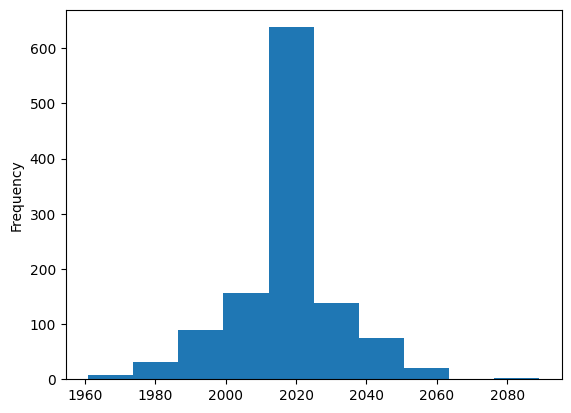

In [18]:
# Check when was the campaign
df_campaign_clm['dob_yr'] = pd.to_datetime(df_campaign_clm['dob']).dt.year
df_campaign_clm['campaign_yr'] = df_campaign_clm['dob_yr'] + df_campaign_clm['age']

print(df_campaign_clm.loc[is_duplicated, 'campaign_yr'].value_counts().iloc[:4])

# Look at the  histogram for only duplicated 
df_campaign_clm.loc[is_duplicated, 'campaign_yr'].plot(kind='hist');

In [19]:
is_right_age = df_campaign_clm['campaign_yr'].isin([2017, 2018, 2019])
df_campaign_clm.loc[is_duplicated & ~is_right_age].head().transpose()

,28,29,35,40,47
participant_id,5420320000000.0,5420320000000.0,2718770000000.0,4984910000000.0,6696990000000.0
name_title,Mr.,Mr.,NaN,NaN,NaN
first_name,Joseph,Joseph,Dylan,Glen,Kevin
last_name,Price,Price,Sinclair,Bennett,Gray
age,19,19,20,48,53
postcode,EH19 0GB,EH19 0GB,EH1R 4LY,EH7 7ES,SN3 6NH
marital_status,Never-married,Never-married,Never-married,Never-married,Married-civ-spouse
education,HS-grad,HS-grad,Some-college,11th,Bachelors
job_title,Health visitor,Health visitor,Event organiser,Medical physicist,"Accountant, chartered certified"
occupation_level,4,4,6,8,7


In [20]:
df_campaign_clm.loc[is_duplicated & df_campaign_clm['participant_id'].isin([5420320000000.0])].transpose()

,27,28,29
participant_id,5420320000000.0,5420320000000.0,5420320000000.0
name_title,Mr.,Mr.,Mr.
first_name,Joseph,Joseph,Joseph
last_name,Price,Price,Price
age,19,19,19
postcode,EH19 0GB,EH19 0GB,EH19 0GB
marital_status,Never-married,Never-married,Never-married
education,HS-grad,HS-grad,HS-grad
job_title,Health visitor,Health visitor,Health visitor
occupation_level,4,4,4


In [21]:
df_campaign_clm_cl = df_campaign_clm.drop(df_campaign_clm[is_duplicated & ~is_right_age].index).copy()
print(f'Number of records: {len(df_campaign_clm_cl)}')
print(f'Number of Duplicated participants: {df_campaign_clm_cl["participant_id"].duplicated(keep=False).sum()}')

Number of records: 3036
Number of Duplicated participants: 70


In [22]:
# Refresh the flag for the duplicated (we dropped some where we kept one which still has the flag)
is_duplicated = df_campaign_clm_cl['participant_id'].duplicated(keep=False)

df_campaign_clm_cl.loc[:, 'duplicated'] = 0
df_campaign_clm_cl.loc[is_duplicated, 'duplicated'] = 1

# look at a few remainders
df_campaign_clm_cl[is_duplicated].head().transpose()

,23,24,71,72,344
participant_id,3513160000000.0,3513160000000.0,4075150000000.0,4075150000000.0,1662520000000.0
name_title,NaN,NaN,Mr.,Mr.,NaN
first_name,Christian,Christian,Edward,Edward,Samuel
last_name,Smith,Smith,Brown,Brown,Hill
age,43,43,30,30,30
postcode,EH10 9TB,EH10 9TB,EH40 6RP,EH40 6RP,EH93 0UW
marital_status,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse,Divorced
education,11th,11th,Bachelors,Bachelors,HS-grad
job_title,Games developer,Games developer,"Designer, ceramics/pottery","Designer, ceramics/pottery","Engineer, civil (consulting)"
occupation_level,9,9,4,4,3


In [23]:
# Use Postcode and postcode areas

# Get post area code from postcode
df_campaign_clm_cl['postcode_area_code'] = df_campaign_clm_cl['postcode'].str.split(pat='\d', regex=True, expand=True)[0]

# Get post area code from town
df_campaign_clm_cl['town_area_code'] = make_data.get_postcode_area(df_campaign_clm_cl['town'])

In [24]:
# check if duplicated
is_duplicated = df_campaign_clm_cl['duplicated']==1

# Check postal area code match i.e
is_postarea_match = df_campaign_clm_cl['postcode_area_code']==df_campaign_clm_cl['town_area_code']

df_campaign_clm_cl[is_duplicated & ~is_postarea_match].sort_values('participant_id').head(3).transpose()

,2338,2771,989
participant_id,191783000000.0,392298000000.0,1250670000000.0
name_title,NaN,Mr.,NaN
first_name,Neil,Toby,Damian
last_name,Green,Wilson,Wood
age,30,46,56
postcode,LS4C 3UF,EH72 5SF,SN9J 8RT
marital_status,Never-married,Divorced,Married-civ-spouse
education,Bachelors,HS-grad,Some-college
job_title,Insurance account manager,Furniture conservator/restorer,Herbalist
occupation_level,12,1,4


In [25]:
df_campaign_clm_cl.loc[is_duplicated & df_campaign_clm_cl['participant_id'].isin([1250670000000.0])].transpose()

,987,989
participant_id,1250670000000.0,1250670000000.0
name_title,NaN,NaN
first_name,Damian,Damian
last_name,Wood,Wood
age,56,56
postcode,SN9J 8RT,SN9J 8RT
marital_status,Married-civ-spouse,Married-civ-spouse
education,Some-college,Some-college
job_title,Herbalist,Herbalist
occupation_level,4,4


In [26]:
df_campaign_clm_cl_cl = df_campaign_clm_cl.drop(df_campaign_clm_cl[is_duplicated & ~is_postarea_match].index)

In [27]:
df_campaign_clm_cl_cl[df_campaign_clm_cl_cl['participant_id'].duplicated(keep=False)].sort_values('participant_id').head(6).transpose()

,1013,1012,2574,2573,344,345
participant_id,573369000000.0,573369000000.0,1228910000000.0,1228910000000.0,1662520000000.0,1662520000000.0
name_title,NaN,NaN,NaN,NaN,NaN,NaN
first_name,Tom,Tom,Mitchell,Mitchell,Samuel,Samuel
last_name,Green,Green,Wright,Wright,Hill,Hill
age,63,63,20,20,30,30
postcode,EH8Y 7BR,EH8Y 7BR,EH54 3BG,EH54 3BG,EH93 0UW,EH93 0UW
marital_status,Widowed,Widowed,Never-married,Never-married,Divorced,Divorced
education,HS-grad,HS-grad,Some-college,Some-college,HS-grad,HS-grad
job_title,Dancer,Dancer,Designer,Designer,"Engineer, civil (consulting)","Engineer, civil (consulting)"
occupation_level,9,9,11,11,3,3


In [28]:
# Are there any more duplicated participants
print(len(df_campaign_clm_cl_cl[df_campaign_clm_cl_cl['participant_id'].duplicated(keep=False)]))
df_campaign_clm_cl_cl[df_campaign_clm_cl_cl['participant_id'].duplicated(keep=False)].head(6).transpose()

26


,344,345,637,638,669,685
participant_id,1662520000000.0,1662520000000.0,3314170000000.0,3314170000000.0,7696770000000.0,4347620000000.0
name_title,NaN,NaN,Mr.,Mr.,NaN,NaN
first_name,Samuel,Samuel,Damian,Damian,Martyn,Allan
last_name,Hill,Hill,Johnson,Johnson,Hughes,Anderson
age,30,30,37,37,35,28
postcode,EH93 0UW,EH93 0UW,SN7U 7RY,SN7U 7RY,SN9X 7NP,EH26 7XY
marital_status,Divorced,Divorced,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse,Never-married
education,HS-grad,HS-grad,Some-college,Some-college,Some-college,Bachelors
job_title,"Engineer, civil (consulting)","Engineer, civil (consulting)","Journalist, newspaper","Journalist, newspaper",Medical physicist,Senior Data Scientist
occupation_level,3,3,7,7,8,11


# Clean `salary_band`  <a id='2'></a>

In [29]:
df_campaign_clm_cl_cl['salary_band'].unique()

array(['£18109 yearly', '£16945 yearly', '£729.87 pw', ..., 'ETC',
       '£13536 yearly', '£1568.86 per month'], dtype=object)

In [30]:
# break up the column to separate fields
df_campaign_clm_cl_cl[['sal_lower', 'sal_upper', 'sal_freq', 'sal_currency']] = df_campaign_clm_cl_cl['salary_band'].apply(make_data.clean_salary_band)

# get rows where we have no valid value
is_no_sal = (df_campaign_clm_cl_cl[['sal_lower', 'sal_upper', 'sal_freq', 'sal_currency']]==0).any(axis=1)
df_campaign_clm_cl_cl.loc[is_no_sal, 'salary_band'].unique()

array([nan, 'BC', 'BCH', 'XDN', 'EOS', 'NXT', 'FTH', 'NMC', 'MZC', 'XMR',
       'ETC'], dtype=object)

In [31]:
# Convert the salary values to numeric data type
df_campaign_clm_cl_cl['sal_lower'] = pd.to_numeric(df_campaign_clm_cl_cl['sal_lower'], errors='coerce')
df_campaign_clm_cl_cl['sal_upper'] = pd.to_numeric(df_campaign_clm_cl_cl['sal_upper'], errors='coerce')

## Convert Salaries
- Convert to GBP
- Convert to per annum

In [32]:
df_campaign_clm_cl_cl.head()

,participant_id,name_title,first_name,last_name,age,postcode,marital_status,education,job_title,occupation_level,...,demographic_characteristic,duplicated,dob_yr,campaign_yr,postcode_area_code,town_area_code,sal_lower,sal_upper,sal_freq,sal_currency
0,8.997000e+12,Mr.,Dale,Coles,39,EH4 9FL,Never-married,Bachelors,Furniture conservator/restorer,1,...,77516.0,0,1979.0,2018.0,EH,EH,18109.00,18109.00,yearly,GBP
1,2.764970e+12,NaN,Joel,Allen,50,LS5H 0JG,Married-civ-spouse,Bachelors,"Administrator, sports",4,...,83311.0,0,1968.0,2018.0,LS,LS,16945.00,16945.00,yearly,GBP
2,8.454880e+12,Mr.,Craig,Davis,38,EH8W 2QJ,Divorced,HS-grad,Armed forces training and education officer,12,...,215646.0,0,1979.0,2017.0,EH,EH,729.87,729.87,pw,GBP
3,5.781320e+12,Mr.,Brandon,Thornton,53,EH2 5UE,Married-civ-spouse,11th,Facilities assistant,1,...,234721.0,0,1965.0,2018.0,EH,EH,19087.00,19087.00,yearly,GBP
4,8.687490e+12,Miss,Brett,Fletcher,28,SN19 0PU,Married-civ-spouse,Bachelors,Information systems manager,12,...,338409.0,0,1990.0,2018.0,SN,SN,2741.50,2741.50,per month,GBP


In [33]:
# Unique values of currencies
df_campaign_clm_cl_cl['sal_currency'].value_counts()

GBP    2342
LKR       6
AMD       5
MZN       4
XOF       4
       ... 
ISK       1
MMK       1
HRK       1
BBD       1
CNY       1
Name: sal_currency, Length: 130, dtype: int64

In [36]:
# Get currency conversion rates
df_campaign_clm_cl_cl['sal_togbp_rate'] = pd.to_numeric(make_data.get_currency_rates(df_campaign_clm_cl_cl['sal_currency']),
                                                        errors='coerce')

Unable to convert currency, failed to fetch results from Google
Unable to convert currency, failed to fetch results from Google


         sal_mid_gbp
count    2315.000000
mean    28395.988052
std     16944.316538
min     13072.560000
25%     19036.000000
50%     22992.840000
75%     31857.730000
max    212457.500000


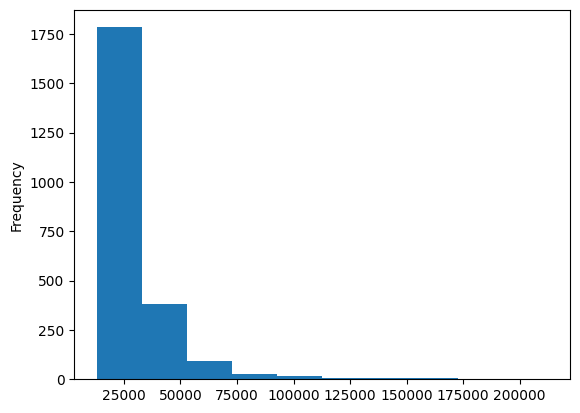

In [44]:
# Apply conversion factors to convert frequencies to per annum
df_campaign_clm_cl_cl['sal_freq'].unique()
freq_conversion_factor = {'yearly': 1, 'pw': 52, 'per month': 12}

df_campaign_clm_cl_cl['sal_toyearly_factor'] = df_campaign_clm_cl_cl['sal_freq'].map(freq_conversion_factor)


# Get a single value (middle of the range) converted to GBP/annum
df_campaign_clm_cl_cl['sal_mid_gbp'] = (df_campaign_clm_cl_cl['sal_upper']+df_campaign_clm_cl_cl['sal_lower'])/2 \
                                        * df_campaign_clm_cl_cl['sal_togbp_rate'] \
                                        * df_campaign_clm_cl_cl['sal_toyearly_factor']

print(df_campaign_clm_cl_cl[['sal_mid_gbp']].describe())
df_campaign_clm_cl_cl['sal_mid_gbp'].plot(kind='hist');

In [45]:
df_campaign_clm_cl_cl[df_campaign_clm_cl_cl['sal_mid_gbp']>200_000].transpose()

,3468
participant_id,2336520000000.0
name_title,Dr.
first_name,Wayne
last_name,Day
age,40
postcode,L9 0QD
marital_status,Never-married
education,Prof-school
job_title,Prime Minister
occupation_level,20


## Duplicates

In [41]:
print('Duplicated participants: ', len(df_campaign_clm_cl_cl[df_campaign_clm_cl_cl['participant_id'].duplicated(keep=False)]))

Duplicated participants:  26


In [42]:
df_campaign_clm_cl_cl = df_campaign_clm_cl_cl.drop_duplicates(subset='participant_id', keep=False)

## Save cleaned data

In [43]:
df_campaign_clm_cl_cl.to_parquet('../data/1_interim/1_merged_data.parquet')